In [1]:
import numpy as np
from scipy.special import log_softmax
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [5]:
def load_steps(dataset, size, method="dpcal", old=True):
    steps = []
    for seed in range(5):
        filename = f"../outputs/{'old/' if old else ''}lora_plus_{method}/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-0.7/0.0-0.3/0.7-1.0/state.ckpt"
        state = torch.load(filename, weights_only=False)
        steps.append(state["best_step_count"])
    return steps

def load_params(dataset, size, method="dpcal", old=True):
    alphas, betas = [], []
    for seed in range(5):
        filename = f"../outputs/{'old/' if old else ''}lora_plus_{method}/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-0.7/0.0-0.3/0.7-1.0/state.ckpt"
        state = torch.load(filename, weights_only=False)
        alphas.append(state['best_model']['alpha'].cpu().item())
        betas.append(state['best_model']['beta'].cpu().numpy().astype(float))
    return alphas, betas

def load_priors(dataset, size):
    priors = []
    for seed in range(5):
        filename = f"../outputs/finetune_lora/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-0.7/0.0-0.3/test={dataset}/list=0.7-1.0"
        labels = pd.read_csv(f"{filename}/labels.csv", header=None, index_col=0).values.astype(int).flatten()
        priors.append(np.bincount(labels) / len(labels))
    return priors

def compute_ner(dataset, size, method="dpcal", old=True):
    ner = []
    for seed in range(5):
        filename = f"../outputs/{'old/' if old else ''}lora_plus_{method}/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-0.7/0.0-0.3/0.7-1.0/test={dataset}/list=test_400"
        logits = pd.read_csv(f"{filename}/logits.csv", header=None, index_col=0).values.astype(float)
        labels = pd.read_csv(f"{filename}/labels.csv", header=None, index_col=0).values.astype(int).flatten()
        priors = np.bincount(labels) / len(labels)
        er = np.mean(logits.argmax(axis=1) != labels)
        er_priors = np.mean(priors.argmax() != labels)
        ner.append(er / er_priors)
    return ner

def compute_nce(dataset, size, method="dpcal", old=True):
    nce = []
    for seed in range(5):
        filename = f"../outputs/{'old/' if old else ''}lora_plus_{method}/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-0.7/0.0-0.3/0.7-1.0/test={dataset}/list=test_400"
        logits = pd.read_csv(f"{filename}/logits.csv", header=None, index_col=0).values.astype(float)
        logits = log_softmax(logits, axis=1)
        labels = pd.read_csv(f"{filename}/labels.csv", header=None, index_col=0).values.astype(int).flatten()
        priors = np.bincount(labels) / len(labels)
        ce = -np.mean(logits[np.arange(len(labels)), labels])
        ce_priors = -np.mean(np.log(priors[labels]))
        nce.append(ce / ce_priors)
    return nce

def load_test_priors(dataset, size, method="dpcal", old=True):
    # filename = f"../outputs/finetune_lora/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-0.7/0.0-0.3/test={dataset}/list=0.7-1.0"
    filename = f"../outputs/{'old/' if old else ''}lora_plus_{method}/llama3.2-1b-instruct/{dataset}/size={size}/seed=0/lora_ans_no_es/0.0-0.7/0.0-0.3/0.7-1.0/test={dataset}/list=test_400"
    labels = pd.read_csv(f"{filename}/labels.csv", header=None, index_col=0).values.astype(int).flatten()
    priors = np.bincount(labels) / len(labels)
    return priors


dataset = "sst2"
size = 32
method = "tempscaling"
old = False
steps = load_steps(dataset, size, method, old=old)
alphas, betas = load_params(dataset, size, method, old=old)
train_priors = load_priors(dataset, size)
ner = compute_ner(dataset, size, method, old=old)
nce = compute_nce(dataset, size, method, old=old)
test_priors = load_test_priors(dataset, size, method, old=old)
print("Test priors:", test_priors)

pd.DataFrame({
    "steps": steps,
    "alphas": alphas,
    "betas": betas,
    "ner": ner,
    "nce": nce,
    "train_priors": train_priors
}, index=pd.Index(range(5), name="seed"))

Test priors: [0.49 0.51]


,steps,alphas,betas,ner,nce,train_priors
seed,,,,,,
0,1568,0.272969,"[0.0, 0.0]",0.163265,0.344810,"[0.47368421052631576, 0.5263157894736842]"
1,1576,0.280585,"[0.0, 0.0]",0.173469,0.374176,"[0.631578947368421, 0.3684210526315789]"
2,1467,0.350538,"[0.0, 0.0]",0.163265,0.377032,"[0.47368421052631576, 0.5263157894736842]"
3,1,1.000000,"[0.0, 0.0]",0.137755,0.662122,"[0.42105263157894735, 0.5789473684210527]"
4,1424,0.436886,"[0.0, 0.0]",0.158163,0.364137,"[0.7368421052631579, 0.2631578947368421]"


In [4]:
dataset = "agnews"
size = 8
method = "tempscaling"
old = False
steps = load_steps(dataset, size, method, old=old)
alphas, betas = load_params(dataset, size, method, old=old)
train_priors = load_priors(dataset, size)
ner = compute_ner(dataset, size, method, old=old)
nce = compute_nce(dataset, size, method, old=old)
test_priors = load_test_priors(dataset, size, method, old=old)
print("Test priors:", test_priors)

pd.DataFrame({
    "steps": steps,
    "alphas": alphas,
    "betas": betas,
    "ner": ner,
    "nce": nce,
    "train_priors": train_priors
}, index=pd.Index(range(5), name="seed"))

Test priors: [0.23   0.2625 0.2575 0.25  ]


,steps,alphas,betas,ner,nce,train_priors
seed,,,,,,
0,2,1.000133,"[0.0, 0.0, 0.0, 0.0]",0.305085,0.772099,[1.0]
1,2,1.000152,"[0.0, 0.0, 0.0, 0.0]",0.159322,0.350738,"[0.25, 0.0, 0.5, 0.25]"
2,2687,0.085351,"[0.0, 0.0, 0.0, 0.0]",0.383051,0.737915,"[0.0, 0.5, 0.5]"
3,567,0.664049,"[0.0, 0.0, 0.0, 0.0]",0.233898,0.401422,"[0.25, 0.5, 0.0, 0.25]"
4,1196,1.521518,"[0.0, 0.0, 0.0, 0.0]",0.230508,0.685006,"[0.0, 0.25, 0.25, 0.5]"


Calibrated CE: 0.20321426528170855
Calibrated NCE: 0.35259800781306166


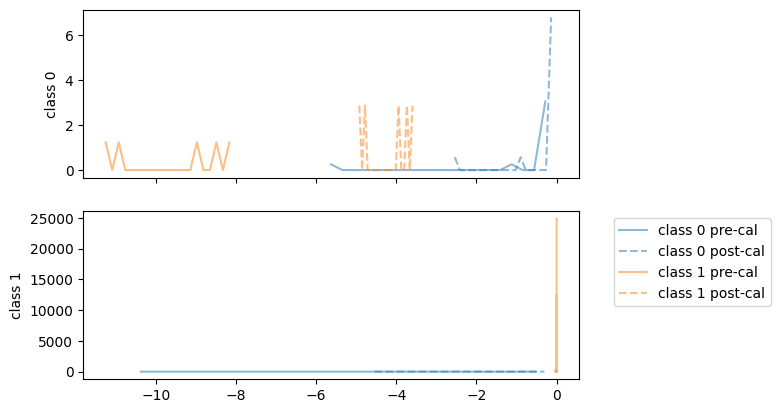

In [46]:
def plot_distributions(dataset, size, seed, nbins=20, method="dpcal"):

    # Miscalibrated posteriors
    filename = f"../outputs/finetune_lora/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-0.7/0.0-0.3/test={dataset}/list=0.7-1.0"
    miscal_logits = pd.read_csv(f"{filename}/logits.csv", header=None, index_col=0).values.astype(float)
    miscal_logits = log_softmax(miscal_logits, axis=1)
    miscal_labels = pd.read_csv(f"{filename}/labels.csv", header=None, index_col=0).values.astype(int).flatten()

    # Calibrated posteriors
    filename = f"../outputs/old/lora_plus_{method}/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-0.7/0.0-0.3/0.7-1.0/state.ckpt"
    state = torch.load(filename, weights_only=False)
    alpha, beta = state["best_model"]["alpha"].cpu().numpy(), state["best_model"]["beta"].cpu().numpy()
    cal_logits = log_softmax(miscal_logits * alpha + beta, axis=1)
    cal_labels = miscal_labels.copy()

    ce = -np.mean(cal_logits[np.arange(len(cal_labels)), cal_labels])
    priors = np.bincount(cal_labels) / len(cal_labels)
    ce_priors = -np.mean(np.log(priors[cal_labels]))
    print("Calibrated CE:", ce)
    print("Calibrated NCE:", ce / ce_priors)

    num_classes = miscal_logits.shape[1]
    fig, ax = plt.subplots(num_classes, 1, sharex=True)
    for i in range(num_classes):
        for j in range(num_classes):
            # hist, edges = np.histogram(miscal_logits[miscal_labels==j, i]-miscal_logits[miscal_labels==j, 0], bins=nbins, density=True)
            # ax[i].plot(edges[:-1], hist, label=f'class {j} pre-cal', alpha=0.5, color=f'C{j}', linestyle='-')
            # hist, edges = np.histogram(cal_logits[cal_labels==j, i]-cal_logits[cal_labels==j, 0], bins=nbins, density=True)
            # ax[i].plot(edges[:-1], hist, label=f'class {j} post-cal', alpha=0.5, color=f'C{j}', linestyle='--')
            hist, edges = np.histogram(miscal_logits[miscal_labels==j, i], bins=nbins, density=True)
            ax[i].plot(edges[:-1], hist, label=f'class {j} pre-cal', alpha=0.5, color=f'C{j}', linestyle='-')
            hist, edges = np.histogram(cal_logits[cal_labels==j, i], bins=nbins, density=True)
            ax[i].plot(edges[:-1], hist, label=f'class {j} post-cal', alpha=0.5, color=f'C{j}', linestyle='--')
            # hist, edges, bar = ax[i].hist(miscal_logits[miscal_labels==j, i], bins=nbins, density=True, label=f'class {j} pre-cal', alpha=0.5, color=f'C{j}')
            # print(hist, edges)

            # print(miscal_logits[miscal_labels==j, i])
            # ax[i].hist(cal_logits[cal_labels==j, i], bins=nbins, density=True, label=f'class {j} post-cal', alpha=0.5, color=f'C{j}')
        ax[i].set_ylabel(f'class {i}')
    ax[-1].legend(loc='upper right', bbox_to_anchor=(1.4, 1))
    
plot_distributions(dataset, size, 4, nbins=20, method=method)

Calibrated CE: 0.20321426528170855
Calibrated NCE: 0.35259800781306166


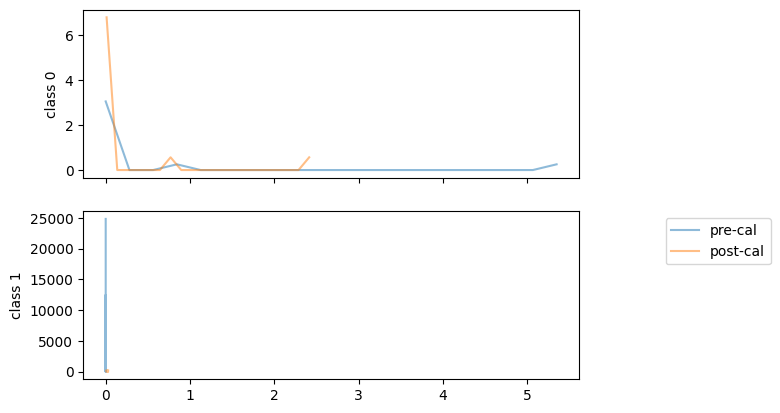

In [49]:
def plot_scores(dataset, size, seed, nbins=20, method="dpcal"):

    # Miscalibrated posteriors
    filename = f"../outputs/finetune_lora/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-0.7/0.0-0.3/test={dataset}/list=0.7-1.0"
    miscal_logits = pd.read_csv(f"{filename}/logits.csv", header=None, index_col=0).values.astype(float)
    miscal_logits = log_softmax(miscal_logits, axis=1)
    miscal_labels = pd.read_csv(f"{filename}/labels.csv", header=None, index_col=0).values.astype(int).flatten()

    # Calibrated posteriors
    filename = f"../outputs/old/lora_plus_{method}/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-0.7/0.0-0.3/0.7-1.0/state.ckpt"
    state = torch.load(filename, weights_only=False)
    alpha, beta = state["best_model"]["alpha"].cpu().numpy(), state["best_model"]["beta"].cpu().numpy()
    cal_logits = log_softmax(miscal_logits * alpha + beta, axis=1)
    cal_labels = miscal_labels.copy()

    ce = -np.mean(cal_logits[np.arange(len(cal_labels)), cal_labels])
    priors = np.bincount(cal_labels) / len(cal_labels)
    ce_priors = -np.mean(np.log(priors[cal_labels]))
    print("Calibrated CE:", ce)
    print("Calibrated NCE:", ce / ce_priors)

    num_classes = miscal_logits.shape[1]
    fig, ax = plt.subplots(num_classes, 1, sharex=True)
    for i in range(num_classes):
        miscal_scores = -miscal_logits[miscal_labels==i,i]
        hist, edges = np.histogram(miscal_scores, bins=nbins, density=True)
        ax[i].plot(edges[:-1], hist, label=f'pre-cal', alpha=0.5, color=f'tab:blue', linestyle='-')
        cal_scores = -cal_logits[cal_labels==i,i]
        hist, edges = np.histogram(cal_scores, bins=nbins, density=True)
        ax[i].plot(edges[:-1], hist, label=f'post-cal', alpha=0.5, color=f'tab:orange', linestyle='-')
        ax[i].set_ylabel(f'class {i}')
    ax[-1].legend(loc='upper right', bbox_to_anchor=(1.4, 1))
    
plot_scores(dataset, size, 4, nbins=20, method=method)

In [41]:
from psrcal.calibration import AffineCalLogLoss
import torch

def calibrate(dataset, size, seed):

    # Miscalibrated posteriors
    filename = f"../outputs/finetune_lora/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-0.7/0.0-0.3/test={dataset}/list=0.7-1.0"
    miscal_logits = pd.read_csv(f"{filename}/logits.csv", header=None, index_col=0).values.astype(float)
    miscal_logits = torch.from_numpy(log_softmax(miscal_logits, axis=1))
    miscal_labels = torch.from_numpy(pd.read_csv(f"{filename}/labels.csv", header=None, index_col=0).values.astype(int).flatten())

    model = AffineCalLogLoss(miscal_logits, miscal_labels, bias=True, scale=True, priors=None)
    model.train()

    cal_logits = model.calibrate(miscal_logits).cpu().detach().numpy()
    cal_labels = miscal_labels.cpu().detach().numpy()

    ce = -np.mean(cal_logits[np.arange(len(cal_labels)), cal_labels])
    priors = np.bincount(cal_labels) / len(cal_labels)
    ce_priors = -np.mean(np.log(priors[cal_labels]))
    print("Calibrated CE:", ce)
    print("Calibrated NCE:", ce / ce_priors)
    print("alpha:", model.temp)

calibrate("sst2", 32, 4)

Calibrated CE: 2.2178437021873257e-06
Calibrated NCE: 3.848190824339659e-06
alpha: Parameter containing:
tensor(9.0929, dtype=torch.float64, requires_grad=True)
